In [3]:
#keras_timeseries.py
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten    
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from keras import backend as K

#df = pd.read_csv("customers_timeseries_updated.csv")
df = pd.read_csv("100_timeseries_checking_to_share.csv")

#use column names
df = df[['client_debtor_number','dates','fv_cost']]

# number of customers
len(df['client_debtor_number'].unique())

101

In [4]:
# try different customers , 1015130-mostly zero with one dip
# 1015193 - more debt after some time,

df_1015130 = df[df['client_debtor_number'] == 1015193]
df_1015130.head()
del df_1015130['client_debtor_number']
# to get client number from list of client numbers use; 
#df[df['client_number'].isin(list_of_values)]\n",
#frequency counts for each customer
# df['client_number'].value_counts()

#df_1015130['client_debtor_number'].value_counts()

In [5]:
#%matplotlib inline
#import seaborn; seaborn.set()
#df_1015130.plot()

print(df_1015130['dates'])
df_1015130.head()


3192    01/01/2010
3193    02/01/2010
3194    03/01/2010
3195    04/01/2010
3196    05/01/2010
3197    06/01/2010
3198    07/01/2010
3199    08/01/2010
3200    09/01/2010
3201    10/01/2010
3202    11/01/2010
3203    12/01/2010
3204    13/01/2010
3205    14/01/2010
3206    15/01/2010
3207    16/01/2010
3208    17/01/2010
3209    18/01/2010
3210    19/01/2010
3211    20/01/2010
3212    21/01/2010
3213    22/01/2010
3214    23/01/2010
3215    24/01/2010
3216    25/01/2010
3217    26/01/2010
3218    27/01/2010
3219    28/01/2010
3220    29/01/2010
3221    30/01/2010
           ...    
6640    29/08/2018
6641    30/08/2018
6642    31/08/2018
6643    01/09/2018
6644    02/09/2018
6645    03/09/2018
6646    04/09/2018
6647    05/09/2018
6648    06/09/2018
6649    07/09/2018
6650    08/09/2018
6651    09/09/2018
6652    10/09/2018
6653    11/09/2018
6654    12/09/2018
6655    13/09/2018
6656    14/09/2018
6657    15/09/2018
6658    16/09/2018
6659    17/09/2018
6660    18/09/2018
6661    19/0

,dates,fv_cost
3192,01/01/2010,0.0
3193,02/01/2010,0.0
3194,03/01/2010,0.0
3195,04/01/2010,0.0
3196,05/01/2010,0.0


In [6]:
#df[df.Date.str.match(r'^2018-06')]
#df[df[\"col\"].str.contains('this|that')==False]
# splitting train and test datasets 
#training 2010-2017, testing on 2018 data\
train_x = df_1015130[df_1015130['dates'].str.contains('/2018') == False]
test_x = df_1015130[df_1015130['dates'].str.contains('/2018') == True]
#print(test_x.dates)
train_x_cust = train_x['fv_cost']
test_x_cust = test_x['fv_cost']

print("train_data ",train_x_cust)
print("test_data ", test_x_cust)

train_data  3192       0.000000
3193       0.000000
3194       0.000000
3195       0.000000
3196       0.000000
3197       0.000000
3198       0.000000
3199       0.000000
3200       0.000000
3201       0.000000
3202       0.000000
3203       0.000000
3204       0.000000
3205       0.000000
3206       0.000000
3207       0.000000
3208       0.000000
3209       0.000000
3210       0.000000
3211       0.000000
3212       0.000000
3213       0.000000
3214       0.000000
3215       0.000000
3216       0.000000
3217       0.000000
3218       0.000000
3219       0.000000
3220       0.000000
3221       0.000000
           ...     
6354   -5690.307208
6355   -5693.596074
6356   -5693.596074
6357   -5693.596074
6358   -5802.687345
6359   -5806.041864
6360   -5809.396831
6361   -5812.752246
6362   -6011.859327
6363   -6015.335480
6364   -6018.812098
6365   -5768.143897
6366   -5768.143897
6367   -5768.143897
6368   -5853.265493
6369   -5856.640747
6370   -5860.016452
6371   -5863.392609
6372   -

http://drivendata.co/blog/benchmark-cold-start-lstm-deep-learning/

In [7]:
train_x['fv_cost'].describe()

count     3192.000000
mean     -3438.513077
std       4674.396262
min     -24863.169200
25%      -5287.090673
50%      -1821.800782
75%          0.000000
max          0.000000
Name: fv_cost, dtype: float64

In [8]:
#print (train_x[train_x['fv_cost'].str.contains(2016)])
n_input = 2016

train_x[(train_x == n_input).any(1)].stack()[lambda x: x != n_input].unique()

array([], dtype=object)

In [9]:

def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])
    
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))

    df.dropna(inplace=True)
    return df


#lagged_data=pd.DataFrame(lag_feature(train_x_cust))

# X, y format taking the first column (original time series) to be the y
#X = lagged_data.drop('fv_cost', axis=1).values
#y = lagged_data.fv_cost.values

#train_x_cust = lagged_data[:,0]
#train_y_cust = lagged_data[:,1]




def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

train_x_cust,train_y_cust, scaler = prepare_training_data(train_x['fv_cost'], 3)
test_x_cust,test_y_cust,scalar = prepare_training_data(test_x['fv_cost'], 3)
print(train_x_cust.shape)
print(train_y_cust.shape)
print(scaler)

(3189, 1, 3)
(3189,)
MinMaxScaler(copy=True, feature_range=(-1, 1))


In [10]:
# progress bar
from tqdm import tqdm
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  3

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

#add convolution layer

#Convolution2D (https://keras.io/layers/convolutional/) expects the input to be in the format (samples, rows, cols, channels), 
#which is "channels-last". data is in the format (samples, channels, rows, cols). You should be able to fix
#this using the optional keyword data_format = 'channels_first' when declaring the Convolution2D layer else use
# input_shape=(3,1).
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
#model.add(Flatten()) # as flatten is converting data into 1D but we need 3D for our 3lags data here

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))
# we can add dropoutlayer after dense as well again
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

In [11]:
from matplotlib import pyplot
model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
# plot metrics
#pyplot.plot(history.history['mse'])
#pyplot.show()

Epoch 1/10
 - 18s - loss: 0.0847
Epoch 2/10
 - 19s - loss: 0.0563
Epoch 3/10
 - 19s - loss: 0.0532
Epoch 4/10
 - 20s - loss: 0.0519
Epoch 5/10
 - 19s - loss: 0.0485
Epoch 6/10
 - 18s - loss: 0.0443
Epoch 7/10
 - 18s - loss: 0.0403
Epoch 8/10
 - 17s - loss: 0.0348
Epoch 9/10
 - 18s - loss: 0.0326
Epoch 10/10
 - 18s - loss: 0.0304


In [12]:

# Estimate model performance
# default batch size is 32 so we need to give batch size explicitly if we want different batch size or 
# input size should be divisible by batch size for stateful LSTM
trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
#print (math.sqrt(scaler.inverse_transform(testScore)))
scaler.inverse_transform(trainScore)
#scaler.inverse_transform(testScore)

Train Score: 0.26 MSE (0.51 RMSE)
Test Score: 0.24 MSE (0.49 RMSE)
unscaled test score -9397.540099 MSE


array([[-9188.85858328]])

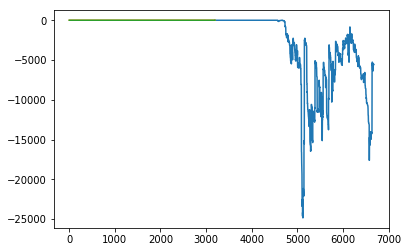

In [13]:
# generate predictions for training
trainPredict = model.predict(train_x_cust,batch_size=1)
testPredict = model.predict(test_x_cust,batch_size=1)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_1015130)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_1015130)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(lag*2)+1:len(df_1015130)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(df_1015130['fv_cost'])
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.show()

In [14]:
# write predictions into csv
result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
#result_prediction['dates'] = test_x['dates']
result_prediction['original_fv'] = test_y_cust
result_prediction['prediction_fv'] = testPredict

result_prediction.to_csv("predictions_for_client_1015193.csv")

Extra code

In [15]:
scaler.inverse_transform(test_y_cust)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.75878621  0.75815513  0.75752396  0.75689271  0.75626138  0.75562996
  0.75562996  0.69999317  0.67483082  0.67415047  0.67347003  0.6727895
  0.67210887  0.67142816  0.67074735  0.64380529  0.69311422  0.69244711
  0.69177992  0.69111263  0.68518199  0.6845113   0.68384052  0.68316966
  0.6824987   0.68182765  0.68115652  0.68048529  0.67981398  0.66689403
  0.72207259  0.72142356  0.70814154  0.70748461  0.70682758  0.70617047
  0.71043435  0.70978001  0.70912558  0.70847107  0.70781647  0.70716178
  0.706507    0.70374683  0.70199974  0.69154391  0.69088083  0.69021765
  0.68955439  0.68889104  0.75455957  0.75393566  0.75867825  0.7580574
  0.75743647  0.75681546  0.75619437  0.75619437  0.72985868  0.72985868
  0.59137962  0.58616359  0.58543926  0.61171779  0.61100945  0.61030101
  0.60959248  0.76237582  0.76175953  0.76114315  0.7605267   0.75991016
  0.75929353  0.75867683  0.75806004  0.75744317  0.75682622  0.75620918
  0.75559207  0.75497487  0.75435758  0.75663275  0.75601694  0.75540106
  0.75478508  0.74069988  0.78920383  0.78860425  0.78860425  0.77720869
  0.77660231  0.77599586  0.77599586  0.53314188  0.53314188  0.52538153
  0.52462222  0.5238628   0.5238628   0.4682062   0.46741297  0.46661964
  0.4658262   0.46503266  0.4621337   0.46133866  0.4605435   0.45974825
  0.45895288  0.45928781  0.4584929   0.36807329  0.36725906  0.33732543
  0.33649314  0.33566075  0.33482825  0.28174626  0.26317491  0.26229924
  0.27390471  0.27303491  0.27216499  0.27129495  0.2577919   0.17113483
  0.1702035   0.16927205  0.16834048  0.16740878  0.17600358  0.17507677
  0.17414984  0.17322279  0.17322279  0.17322279  0.16314669  0.15486466
  0.15392713  0.15298948  0.1520517   0.14479788  0.14175068  0.14080737
  0.13986393  0.13892037  0.13797668  0.13703287  0.12428273  0.12333144
  0.11606445  0.11510903  0.11415349  0.11319782  0.11224202  0.11128609
  0.11128609  0.0854486   0.0854486   0.04771918 -0.07866612 -0.07973707
 -0.08080816 -0.08187939 -0.08295077 -0.08402229 -0.19924733 -0.21568478
 -0.21683628 -0.21798793 -0.21798793 -0.23765362 -0.23881691 -0.23881691
 -0.23881691 -0.24849776 -0.24966658 -0.25083555 -0.25200468 -0.25317397
 -0.26169254 -0.26286663 -0.26404089 -0.2773415  -0.28120303 -0.99866323
 -1.         -1.         -0.94505322 -0.67814085 -0.64706264 -0.53400103
 -0.52989319 -0.53094811 -0.65739443 -0.66035272 -0.67411745 -0.67525857
 -0.68820427 -0.68935293 -0.69050173 -0.6916507  -0.42581015 -0.42683829
 -0.43276598 -0.4337974  -0.43482895 -0.43586064 -0.43689246 -0.44108239
 -0.44211642 -0.44100008 -0.4344243  -0.43545292 -0.43648167 -0.43751056
 -0.42576776 -0.42678926 -0.42781089 -0.42883266 -0.42985457 -0.43087661
 -0.43189879 -0.43292111 -0.43394357 -0.43394357 -0.57015625 -0.44214421
 -0.44317309 -0.4442021  -0.44523126 -0.43759969 -0.42658063 -0.42759787
 -0.43493116 -0.43595254 -0.43697405 -0.4379957  -0.43901749 -0.44003941
 -0.44106147 -0.44208366 -0.45290483 -0.4539333  -0.4549619  -0.45599065
 -0.01572572  0.70579033  0.96186564  0.94662146  0.94610674  1.
  0.99951636  0.99903266  0.9985489   0.99806507  0.96806976  0.96756773
  0.84167438  0.84109545  0.84558143  0.84500537  0.84127128  0.84069313
  0.84011491  0.8395366   0.83580027  0.83416722  0.82378728  0.82320009
  0.82261283  0.82202548  0.95931474  0.97220146  0.97170445  0.97120738
  0.97071024  0.97021303  0.95501751  0.95451117  0.94137187  0.94085766
  0.94625946].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# predictions for timesteps ahead
# 7,14 ,21 timesteps ahead
#we need atleast 4 elements to prepare training data
futureElement = testPredict[-4:]

def prepare_training_data_array(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
print(futureElements[0][0][0][:2])

#future_x = np.array(futureElement,futureElements[0][:2])

In [ ]:
cost_lagged

In [ ]:
_7time_ahead,elements = timestep_ahead(7,model,futureElement,x)
print ("scaled prediction value on 7th day ahead ",_7time_ahead)
_14time_ahead,elements  = timestep_ahead(14,model,futureElement,x)
print ("scaled prediction value on 14th day ahead ",_14time_ahead)
_21time_ahead,elements  = timestep_ahead(21,model,futureElement,x)
print ("scaled prediction value on 21st day ahead ",_21time_ahead)

In [ ]:
# 3months ahead predicitons
_91days_ahead,elements = timestep_ahead(91,model,futureElement,x)
print ("scaled prediction value on 91st day ahead ",_91days_ahead)


In [ ]:
daily_pred =[np.array(arr).tolist() for arr in elements]
daily_pred
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
pred_list = flatten(daily_pred)

import csv 
myFile = open('daily_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)

pred_list

In [ ]:
#find every 7th element into a list
week_end_pred = pred_list[0::7]
week_end_pred

In [ ]:
# weekly average for 3 months
weekly_avg_pred = [(sum(pred_list[x:x+7]))/7 for x in range(0, len(pred_list), 7)]
weekly_avg_pred

# find average for every 7 days
import itertools
n=7 #7days
list_week = list(itertools.chain.from_iterable([i]*7 for i in [sum(pred_list[i:i+7])//7 for i in range(0,len(pred_list),7)]))
list_week


#for i in range(7):
futureElement = model.predict(futureElement,batch_size=1)
futureElements.append(futureElement)
futureElement = np.append(futureElement, futureElements[0][0][0][:3])
x=futureElement[:3]
print(x)
print("iteration 0 complete")
#    #return futureElements
print(futureElement)
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 1 complete")
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 2 complete")
print(futureElements)

print(type(futureElements))
print(type(futureElement))

In [ ]:
flat_list = [x for sublist in futureElements for x in sublist]
print(flat_list[0][0][1])

#above function loops in below format
#for sublist in futureElements:
#    for x in sublist:
#        flat_list.append(x)

In [ ]:
#price.resample('1W')  
#aapl.resample('W').mean()
#http://benalexkeen.com/resampling-time-series-data-with-pandas/
#resampling based on days and then slicing every 7th day
#ts.resample('D').interpolate()[::7]

In [ ]:
#df.last('3M') #last 3 months data
# to sort dates column before getting last 3months
#df_sorted = df.sort_values(by="Date",ascending=True) \
#    .set_index("Date")
#    .last("3M")

https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data

https://stats.stackexchange.com/questions/67362/shall-i-use-weekly-or-monthly-data-for-forecast

In [ ]:
#weekly predicitons
#weekly data
week_data = df_1015130.set_index('dates').resample('1W').mean()
#week_data['dates'] = pd.to_datetime(week_data['dates'], errors='coerce')


week_data = week_data.resample('1W')


In [ ]:
#week_data['dates'] = pd.to_datetime(week_data['dates'], unit='D',utc=True)
week_data = df_1015130
##week_data['New']=week_data.dates.map(week_data.set_index('dates').iloc[1:].resample('D').sum().rolling(7,min_periods =1).visit.mean()).shift()
week_data['dates'] = pd.to_datetime(week_data['dates'])


In [ ]:
week_data.set_index('dates',inplace=True)
week_data_resample = week_data.resample('1W').mean()

In [ ]:
week_data_resample.describe()

In [ ]:
#c_index = week_data_resample.index("/2018")
#l2 = l[:c_index]
week_data_resample['dates'] = week_data_resample.index
week_data_resample['dates']=week_data_resample['dates'].astype(str)
week_data_resample = week_data_resample.fillna(0)

In [ ]:
train_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == False]
test_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == True]

train_x_week,train_y_week, scaler = prepare_training_data(train_week['fv_cost'], 3)
test_x_week,test_y_week,scalar = prepare_training_data(test_week['fv_cost'], 3)
print(train_x_week.shape)
print(train_y_week.shape)
print(scaler)

In [ ]:
train_week

In [ ]:
week_data_resample

In [ ]:
lag =  3
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
model.fit(train_x_week, train_y_week, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)

In [ ]:
trainScore = model.evaluate(train_x_week, train_y_week, batch_size=1, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_x_week, test_y_week, batch_size=1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
scaler.inverse_transform(trainScore)


In [ ]:
# generate predictions for training
trainPredict = model.predict(train_x_week,batch_size=1)
testPredict = model.predict(test_x_week,batch_size=1)

In [ ]:
futureElement = testPredict[-4:]

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead_week(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
_12_weeks_ahead,all_pred = timestep_ahead_week(12,model,futureElement,x)
print ("scaled prediction value on 3rd month ahead ",_12_weeks_ahead)
print ("all predicitons ",all_pred)

In [ ]:
# converting list of arrays to lists
#l = [arr.tolist() for arr in l]
#[l.tolist() for l in list1]

#weekly_pred = [arr.tolist() for arr in all_pred] #list object has no attribute tolist
weekly_pred =[np.array(arr).tolist() for arr in all_pred]
weekly_pred

In [ ]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]

In [ ]:
pred_list = flatten(weekly_pred)
pred_list

In [ ]:
csvwriter.writerow(pred_list)

In [ ]:
import csv 
myFile = open('weekly_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)